In [8]:
import cv2
import numpy as np
import albumentations as A
import random
import os
from albumentations.pytorch import ToTensorV2
import shutil

# Define augmentation pipeline
transform = A.Compose([
    A.RandomBrightnessContrast(p=0.3),  # Adjust brightness & contrast
    A.GaussianBlur(blur_limit=(3, 7), p=0.2),  # Blur to mimic motion or camera focus
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),  # Add noise for robustness
    A.RandomGamma(p=0.3),  # Adjust gamma to simulate different lighting
    A.ISONoise(p=0.2),  # Simulate camera noise
    A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=0.2),  # Improve contrast in low-light conditions
    ToTensorV2()
])


# Process images and copy labels
def augment_images(input_folder, label_folder, output_folder, label_output_folder):
    os.makedirs(output_folder, exist_ok=True)
    os.makedirs(label_output_folder, exist_ok=True)

    image_files = [f for f in os.listdir(input_folder) if f.endswith(('.jpg', '.png'))]

    for image_file in image_files:
        image_path = os.path.join(input_folder, image_file)
        label_path = os.path.join(label_folder, image_file.replace('.jpg', '.txt').replace('.png', '.txt'))

        # Read the image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

        # Apply augmentations
        augmented = transform(image=image)['image']

        # Save augmented image
        augmented_image_path = os.path.join(output_folder, f"aug_{image_file}")
        cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented.numpy().transpose(1, 2, 0), cv2.COLOR_RGB2BGR))

        # Copy the label for the augmented image (same name)
        if os.path.exists(label_path):
            shutil.copy(label_path, os.path.join(label_output_folder, f"aug_{image_file.replace('.jpg', '.txt').replace('.png', '.txt')}"))


        

# Example usage
augment_images("../multiple/images/train", "../multiple/labels/train", "./augmented/images", "./augmented/labels")


In [9]:
import os
import cv2
import pandas as pd
import random

def process_videos(video_folder, csv_folder, augmented_folder):
    os.makedirs(augmented_folder, exist_ok=True)
    label_output_folder = os.path.join(augmented_folder, "labels")
    os.makedirs(label_output_folder, exist_ok=True)
    
    for video_file in os.listdir(video_folder):
        if video_file.endswith(('.mp4')):
            video_path = os.path.join(video_folder, video_file)
            csv_path = os.path.join(csv_folder, f"{os.path.splitext(video_file)[0]}.csv")
            
            if not os.path.exists(csv_path):
                continue
            
            selected_frames = pd.read_csv(csv_path)['Frame'].tolist()
            cap = cv2.VideoCapture(video_path)
            frame_count = 0
            
            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break
                
                frame_count += 1
                if frame_count in selected_frames:
                    frame = cv2.resize(frame, (frame.shape[1] // 2, frame.shape[0] // 2))
                    frame_filename = f"{os.path.splitext(video_file)[0]}_frame_{frame_count}.jpg"
                    frame_path = os.path.join(augmented_folder, frame_filename)
                    cv2.imwrite(frame_path, frame)
                    
                    # Create empty label file
                    label_path = os.path.join(label_output_folder, frame_filename.replace('.jpg', '.txt'))
                    with open(label_path, 'w') as f:
                        pass
                
            cap.release()
    
    cv2.destroyAllWindows()

# Usage
video_folder = "../nitasha/video"
csv_folder = "./background"
augmented_folder = "./augmented/images"
process_videos(video_folder, csv_folder, augmented_folder)


In [10]:
# Create data.yaml for YOLO training configuration
data_yaml = f"""
train: /mnt/8tb_hdd/ai1/Nitasha/objectDetection/Data Augmentation/augmented/images
val: /mnt/8tb_hdd/ai1/Nitasha/objectDetection/multiple/images/val

nc: 1
names: ['Litter']
"""

yaml_path = './augmented/data.yaml'
with open(yaml_path, 'w') as f:
    f.write(data_yaml.strip())

print("Processing complete and data.yaml file created.")

Processing complete and data.yaml file created.


1342 286


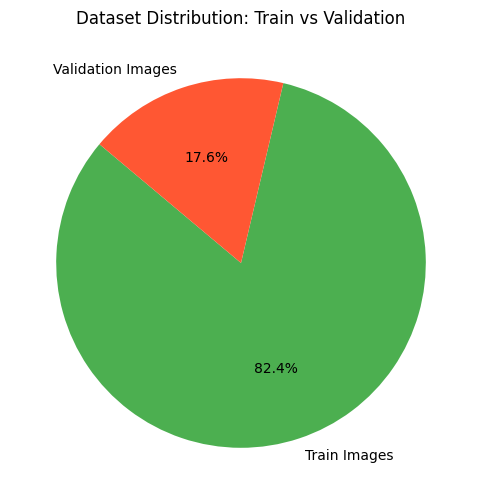

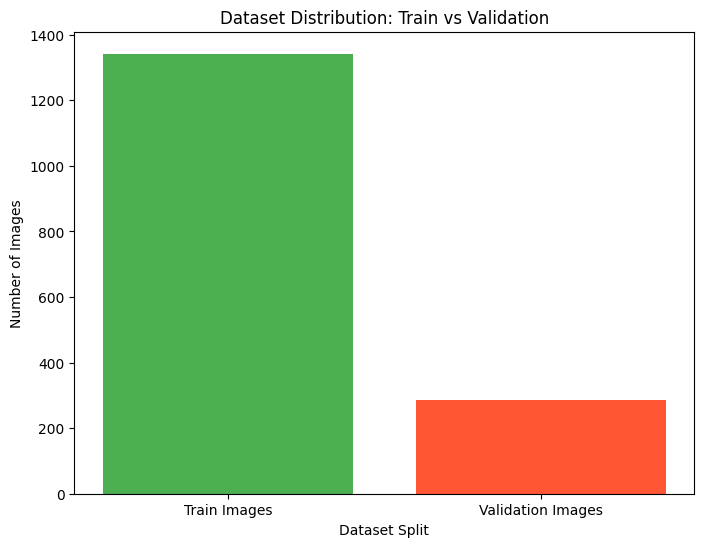

In [11]:
import os
import yaml
import matplotlib.pyplot as plt
from PIL import Image

# Function to load the data.yaml file
def load_data_yaml(yaml_path):
    with open(yaml_path, "r") as file:
        return yaml.safe_load(file)

# Function to count the number of images in the specified directory
def count_images(directory):
    return len([f for f in os.listdir(directory) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

# Function to get image dimensions (optional for size distribution)
def get_image_size(directory):
    sizes = []
    for file in os.listdir(directory):
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img = Image.open(os.path.join(directory, file))
            sizes.append(img.size)
    return sizes

# Path to the data.yaml file
data_yaml_path = './augmented/data.yaml'

# Load dataset information from data.yaml
data_config = load_data_yaml(data_yaml_path)

# Get paths for training and validation images
train_dir = './augmented/images/'
val_dir = '../multiple/images/val'

# Count the number of images in each directory
train_images = count_images(train_dir)
val_images = count_images(val_dir)
print(train_images,val_images)
# Get image sizes for training and validation (optional)
train_sizes = get_image_size(train_dir)
val_sizes = get_image_size(val_dir)

# Create the dataset summary
dataset_summary = {
    'Train Images': train_images,
    'Validation Images': val_images
}

# Plotting the number of images using a pie chart
plt.figure(figsize=(8, 6))
plt.pie(dataset_summary.values(), labels=dataset_summary.keys(), autopct='%1.1f%%', startangle=140, colors=['#4CAF50', '#FF5733'])
plt.title('Dataset Distribution: Train vs Validation')
plt.show()

# Plotting the number of images using a bar chart
plt.figure(figsize=(8, 6))
plt.bar(dataset_summary.keys(), dataset_summary.values(), color=['#4CAF50', '#FF5733'])
plt.title('Dataset Distribution: Train vs Validation')
plt.xlabel('Dataset Split')
plt.ylabel('Number of Images')
plt.show()



📷 Selected Image: aug_20240701083005_6_frame_00086.jpg (1440x1080)
📄 Label File: ./augmented/labels/aug_20240701083005_6_frame_00086.txt
🔹 Label Entry: 0 0.509896 0.160185 0.007292 0.016667
📏 Bounding Box (Pixels): 729, 163, 739, 181


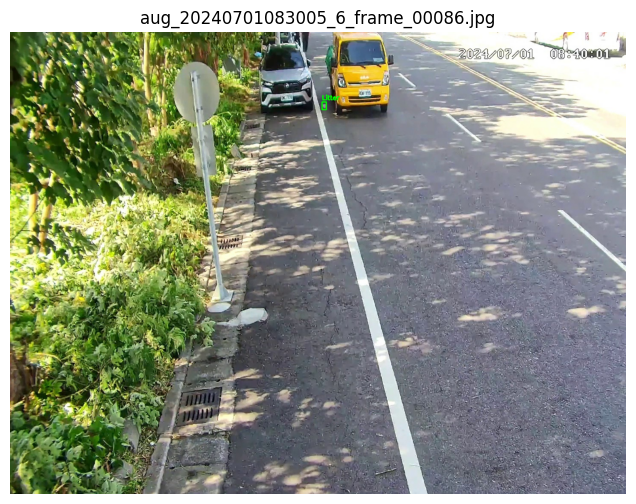

In [12]:
import os
import cv2
import random
import matplotlib.pyplot as plt

# Paths to images and labels
image_folder = "./augmented/images"
label_folder = "./augmented/labels"

# Class names (make sure these match your data.yaml)
class_names = ["Litter"]

def visualize_random_image():
    image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]
    if not image_files:
        print("No images found!")
        return

    image_file = random.choice(image_files)
    image_path = os.path.join(image_folder, image_file)
    label_path = os.path.join(label_folder, image_file.replace('.jpg', '.txt'))

    # Load image
    img = cv2.imread(image_path)
    if img is None:
        print(f"⚠️ Error: Unable to load image {image_path}")
        return
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape  # Image dimensions

    print(f"📷 Selected Image: {image_file} ({w}x{h})")
    print(f"📄 Label File: {label_path}")

    # Load labels
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            lines = f.readlines()
            if not lines:
                print("⚠️ Warning: Label file is empty!")
            for line in lines:
                print(f"🔹 Label Entry: {line.strip()}")
                # Expecting: class_id x_center y_center width height
                class_id, x_center, y_center, box_width, box_height = map(float, line.strip().split())
                
                # --- Conversion from YOLO normalized coordinates to pixel coordinates ---
                # If your labels are in normalized format (values between 0 and 1), use:
                x1 = int((x_center - box_width / 2) * w)
                y1 = int((y_center - box_height / 2) * h)
                x2 = int((x_center + box_width / 2) * w)
                y2 = int((y_center + box_height / 2) * h)
                
                # --- If your labels are already in pixel coordinates, comment the above
                # and use the following instead:
                # x1 = int(x_center - box_width / 2)
                # y1 = int(y_center - box_height / 2)
                # x2 = int(x_center + box_width / 2)
                # y2 = int(y_center + box_height / 2)
                
                print(f"📏 Bounding Box (Pixels): {x1}, {y1}, {x2}, {y2}")

                # Draw bounding box and label
                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                label_text = class_names[int(class_id)] if int(class_id) < len(class_names) else "Unknown"
                cv2.putText(img, label_text, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    else:
        print("⚠️ No label file found for this image!")

    # Display image using matplotlib
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.title(image_file)
    plt.show()

# Run the visualization function
visualize_random_image()


📷 Selected Image: aug_20240809160023_clipped_frame_00028.jpg (2592x1944)
📄 Label File: ./augmented/labels/aug_20240809160023_clipped_frame_00028.txt
🔹 Label Entry: 0 0.252604 0.216667 0.007292 0.014815
📏 Bounding Box (Pixels): 645, 406, 664, 435


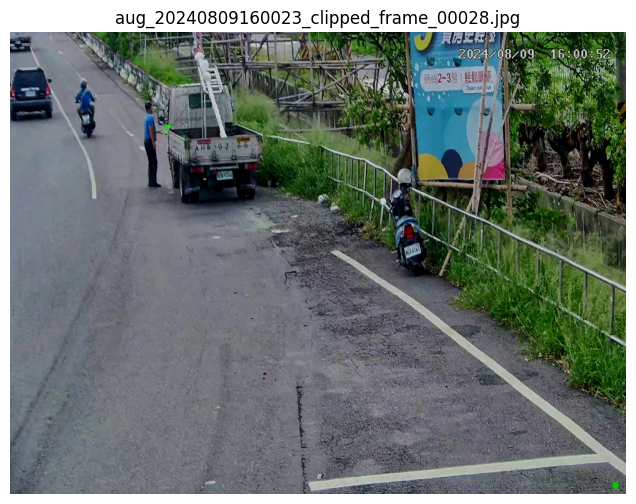

In [59]:
visualize_random_image()
